In [1]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import os
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
from tensorflow.random import set_seed
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
pip install opencv-python


  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pd.options.display.max_colwidth = 100
seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(42)
warnings.filterwarnings('ignore')
IMG_SIZE = 150
SEED = 42

In [3]:
main_path = "C:/Users/harsh/Downloads/data3a"
train_path = os.path.join(main_path,"training")
train_moderate = glob.glob(train_path+"/02-moderate/*.jpeg")
train_minor = glob.glob(train_path+"/01-minor/*.jpeg")
train_severe = glob.glob(train_path+"/03-severe/*.jpeg")

In [9]:
#Train list:
train_list = [x for x in train_moderate]
train_list.extend([x for x in train_minor])
train_list.extend([x for x in train_severe])
df_train = pd.DataFrame(np.concatenate([
                       ['0']*len(train_moderate),
                       ['1']*len(train_minor),
                       ['2']*len(train_severe)]),
                  columns = ['label'])
df_train['image'] = [x for x in train_list]

In [10]:
df_train

,label,image
0,0,C:/Users/harsh/Downloads/data3a\training/02-moderate\0001.JPEG
1,0,C:/Users/harsh/Downloads/data3a\training/02-moderate\0002.JPEG
2,0,C:/Users/harsh/Downloads/data3a\training/02-moderate\0003.JPEG
3,0,C:/Users/harsh/Downloads/data3a\training/02-moderate\0004.JPEG
4,0,C:/Users/harsh/Downloads/data3a\training/02-moderate\0005.JPEG
...,...,...
974,2,C:/Users/harsh/Downloads/data3a\training/03-severe\0382.JPEG
975,2,C:/Users/harsh/Downloads/data3a\training/03-severe\0383.JPEG
976,2,C:/Users/harsh/Downloads/data3a\training/03-severe\0384.JPEG
977,2,C:/Users/harsh/Downloads/data3a\training/03-severe\0385.JPEG


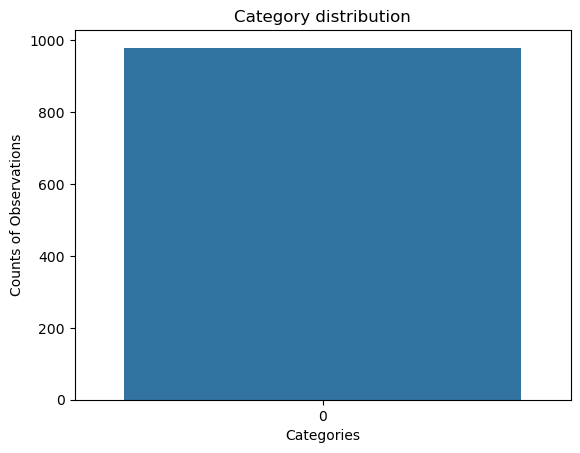

In [11]:
sns.countplot(df_train['label'])
plt.title('Category distribution')
plt.xlabel('Categories')
plt.ylabel('Counts of Observations');

In [12]:
path = 'C:/Users/harsh/Downloads/data3a/training'
#List of image:
img_list = list(df_train['image'])
data_img = []
for each in img_list:
               #Each image path:
               each_path = os.path.join(path, each)
               #Read each image:
               each_img = cv2.imread(each_path)
               #OpenCv default color is BGR. Convert it to RGB:
               each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
               #Resize the images:
               each_img_resized = cv2.resize(each_img, (128,128))
               #Save arrays to a list:
               data_img.append(each_img_resized)
# Converting list to numpy array
X = np.array(data_img)

In [13]:
print('Shape of X: ', X.shape)

Shape of X:  (979, 128, 128, 3)


In [14]:
y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(df_train['label'].values.reshape(-1,1))

In [15]:
print('Shape of y: ', y.shape)

Shape of y:  (979, 3)


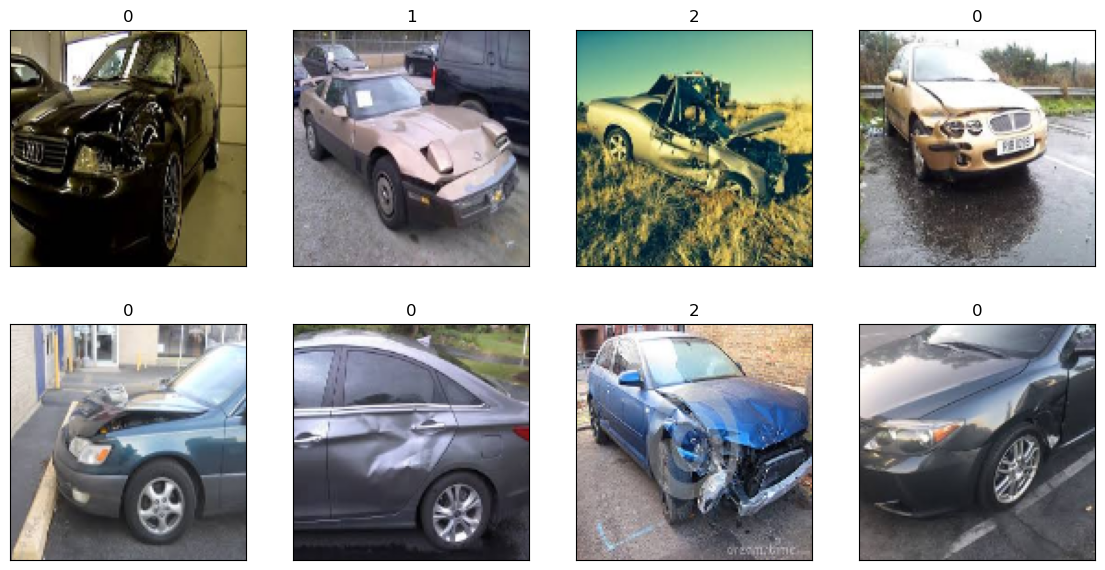

In [16]:
indices = np.random.randint(0,985,8)
i = 1
plt.figure(figsize=(14,7))
for each in indices:
    plt.subplot(2,4,i)
    plt.imshow(X[each])
    plt.title(df_train['label'].loc[each])
    plt.xticks([])
    plt.yticks([])
    i += 1

In [17]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (665, 128, 128, 3)
y_train shape:  (665, 3)
X_val shape  :  (167, 128, 128, 3)
y_val shape  :  (167, 3)
X_test shape :  (147, 128, 128, 3)
y_test shape :  (147, 3)


In [18]:
train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 45,
                                    zoom_range=0.2,
                                    height_shift_range = 0.5,
                                    width_shift_range = 0.5)
train_gen.fit(X_train)
validation_gen.fit(X_val)

In [19]:
#Note that you can decrease batch size and increase number of epochs if you want to maximise your model accuracy:
batch_size = 64
epochs = 10

In [20]:
base = Xception(include_top=False, 
                weights='imagenet', 
                input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)

83683744/83683744 [==============================] - 80s 1us/step


In [21]:
#We use 3, because we have 3 categories:
head = Dense(3, activation='softmax')(x)
model = Model(inputs=base.input, outputs=head)

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)

In [24]:
history = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = 25,
               validation_data = validation_gen.flow(X_val, y_val)
)

Epoch 1/25
11/11 [==============================] - 139s 12s/step - loss: 1.1137 - accuracy: 0.3639 - val_loss: 1.5662 - val_accuracy: 0.2575
Epoch 2/25
11/11 [==============================] - 149s 14s/step - loss: 1.0314 - accuracy: 0.5023 - val_loss: 1.3004 - val_accuracy: 0.3413
Epoch 3/25
11/11 [==============================] - 123s 11s/step - loss: 0.9314 - accuracy: 0.5774 - val_loss: 1.1929 - val_accuracy: 0.4551
Epoch 4/25
11/11 [==============================] - 126s 12s/step - loss: 0.8288 - accuracy: 0.6481 - val_loss: 1.1523 - val_accuracy: 0.4731
Epoch 5/25
11/11 [==============================] - 129s 12s/step - loss: 0.8046 - accuracy: 0.6436 - val_loss: 0.9703 - val_accuracy: 0.5329
Epoch 6/25
11/11 [==============================] - 139s 13s/step - loss: 0.7443 - accuracy: 0.6737 - val_loss: 1.0072 - val_accuracy: 0.5329
Epoch 7/25
11/11 [==============================] - 152s 15s/step - loss: 0.7417 - accuracy: 0.6812 - val_loss: 1.0912 - val_accuracy: 0.5689
Epoch 

5/5 [==============================] - 5s 914ms/step


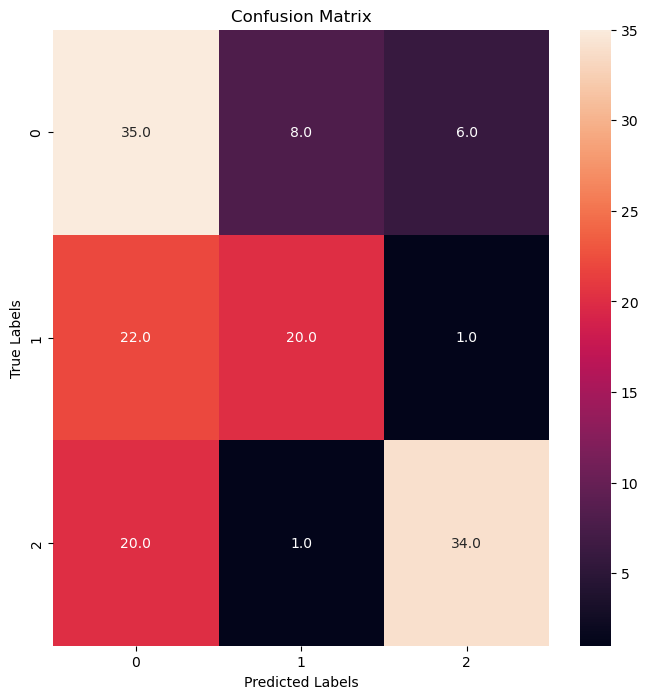

In [25]:
# Predicting labels from X_test data
y_pred = model.predict(X_test)
# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)
# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [26]:
model.save('stage3.h5')

In [27]:
history = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = 8,
               validation_data = validation_gen.flow(X_val, y_val)
)

Epoch 1/8
11/11 [==============================] - 134s 12s/step - loss: 0.3657 - accuracy: 0.8526 - val_loss: 1.0728 - val_accuracy: 0.6407
Epoch 2/8
11/11 [==============================] - 126s 11s/step - loss: 0.3109 - accuracy: 0.8797 - val_loss: 1.0849 - val_accuracy: 0.6108
Epoch 3/8
11/11 [==============================] - 143s 13s/step - loss: 0.2939 - accuracy: 0.8977 - val_loss: 1.1349 - val_accuracy: 0.5808
Epoch 4/8
11/11 [==============================] - 126s 11s/step - loss: 0.3275 - accuracy: 0.8857 - val_loss: 1.1017 - val_accuracy: 0.6766
Epoch 5/8
11/11 [==============================] - 131s 12s/step - loss: 0.3131 - accuracy: 0.8722 - val_loss: 1.1987 - val_accuracy: 0.6347
Epoch 6/8
11/11 [==============================] - 144s 13s/step - loss: 0.2908 - accuracy: 0.8842 - val_loss: 1.1249 - val_accuracy: 0.6168
Epoch 7/8
11/11 [==============================] - 124s 11s/step - loss: 0.2470 - accuracy: 0.9233 - val_loss: 1.0946 - val_accuracy: 0.6707
Epoch 8/8
11/

In [29]:
model.save('stage31.h5')